# Load Data

In [1]:
import pandas as pd

df = pd.read_csv("dataset-2/label.csv")
df.head()


,file_name,fruit_type,cnt
0,img000.png,plum,4
1,img001.png,plum,3
2,img002.png,banana,2
3,img003.png,plum,5
4,img004.png,plum,1


In [2]:
all_fruit_types = ['plum', 'banana', 'strawberry', 'lime']
all_cnt = [1, 2, 3, 4, 5]

def set_label(fruit_type, cnt):
    assert fruit_type in all_fruit_types
    assert cnt in all_cnt

    if fruit_type == 'plum':
        return int(cnt - 1) # 0 ~ 4
    if fruit_type == 'banana':
        return int(cnt + 4) # 5 ~ 9
    if fruit_type == 'strawberry':
        return int(cnt + 9) # 10 ~ 14
    if fruit_type == 'lime':
        return int(cnt + 14) # 15 ~ 19


df['label'] = df.apply(lambda row: set_label(row['fruit_type'], row['cnt']), axis=1)
df.head()

,file_name,fruit_type,cnt,label
0,img000.png,plum,4,3
1,img001.png,plum,3,2
2,img002.png,banana,2,6
3,img003.png,plum,5,4
4,img004.png,plum,1,0


In [3]:
import torch

print("torch version:", torch.__version__)
print("cuda is available?", torch.cuda.is_available())


torch version: 1.5.0
cuda is available? True


file_name: img134.png
image shape: (200, 200, 3)
label: 4


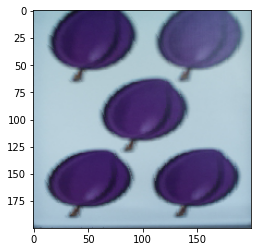

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import random

def get_image_and_label(df=df, idx=None, show=False):
    if idx is None:
        idx = random.randrange(len(df))

    file_name = df.loc[idx]['file_name']

    img = cv2.imread(f"dataset-2/{file_name}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    label = df.loc[idx]['label']

    if show:
        print("file_name:", file_name)
        print("image shape:", img.shape)
        print("label:", label)

        plt.imshow(img)
        plt.show()

    img = torch.from_numpy(img)
    img = img.permute(2, 0, 1)
    img = img.float()

    return img, label

_ = get_image_and_label(show=True)

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MyDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        image, label = get_image_and_label(self.df, index)
        return image, label
        
dataset = MyDataset(df)
print("data:", dataset[0][0].shape, dataset[0][1])

data: torch.Size([3, 200, 200]) 3


# Train and Eval
https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

In [6]:
def train(model, device, criterion, optimizer, batch_size, max_epoch):

    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(max_epoch):
        model.train()
        
        running_loss = 0.0
        correct = 0

        for _, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        
        acc = correct / len(dataset)
        if epoch % 10 == 9:
            print(f"[epoch {epoch + 1}] loss: {running_loss:.4f}, acc: {acc:.2f}")
        

        model.eval()
        correct = 0
        with torch.no_grad():
            for _, data in enumerate(dataloader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        
        if correct == len(dataset):
            print("Early stop!")
            model_name = "best.pt"
            torch.save(model.state_dict(), model_name)
            print(f"Save model as {model_name}")
            break
    
    else:
        print("Try training again")

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=5,
            padding=2
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            padding=2
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=5,
            padding=2
        )
        self.pool = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 20)

    def forward(self, x):
        # x = (B, 3, 200, 200)
        x = self.pool(F.relu(self.conv1(x)))
        # x = (B, 6, 50, 50)
        x = self.pool(F.relu(self.conv2(x)))
        # x = (B, 16, 12, 12)
        x = self.pool(F.relu(self.conv3(x)))
        # x = (B, 32, 3, 3)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyModel()
print(model)
print(
    "trainable parameters:", \
    sum(p.numel() for p in model.parameters() if p.requires_grad)
)


MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)
trainable parameters: 55276


In [8]:
%%time
import torch.optim as optim


model = MyModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 128
train(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=batch_size,
    max_epoch=50
)

[epoch 10] loss: 5.4614, acc: 0.19
[epoch 20] loss: 2.3971, acc: 0.65
[epoch 30] loss: 0.3768, acc: 0.98
Early stop!
Save model as best.pt
CPU times: user 2min 7s, sys: 1.86 s, total: 2min 9s
Wall time: 15.6 s


# Inference

In [9]:
model_name = 'best.pt'
model = MyModel()
model.load_state_dict(torch.load(model_name))
model.eval()

dataloader = DataLoader(dataset, batch_size=len(dataset))
wrong = 0
for _, data in enumerate(dataloader):
    inputs, labels = data
    outputs = model(inputs)
    wrong += (outputs.argmax(1) != labels).type(torch.int).sum().item()

print(f"{wrong} are wrong out of {len(dataset)} images")    

0 are wrong out of 147 images


file_name: img073.png
image shape: (200, 200, 3)
label: 13


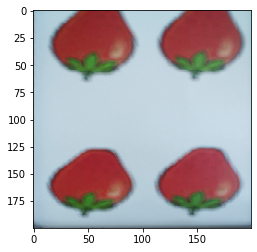

pred: 13, answer: 13
CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 92 ms


In [10]:
%%time
img, answer = get_image_and_label(show=True)
out = model(img.unsqueeze(0))
pred = out.argmax(1).item()
print(f"pred: {pred}, answer: {answer}")

file_name: img090.png
image shape: (200, 200, 3)
label: 5


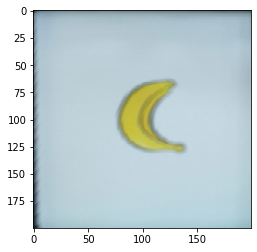

pred: 5, answer: 13
CPU times: user 117 ms, sys: 3.02 ms, total: 120 ms
Wall time: 114 ms


In [14]:
%%time
idx = random.randrange(len(df))

file_name = df.loc[idx]['file_name']

img = cv2.imread(f"dataset-2/{file_name}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.flip(img, 0) # flip

label = df.loc[idx]['label']

print("file_name:", file_name)
print("image shape:", img.shape)
print("label:", label)

plt.imshow(img)
plt.show()

img = torch.from_numpy(img)
img = img.permute(2, 0, 1)
img = img.float()

out = model(img.unsqueeze(0))
pred = out.argmax(1).item()
print(f"pred: {pred}, answer: {label}")